For some reason, the loss goes up if running the following command:

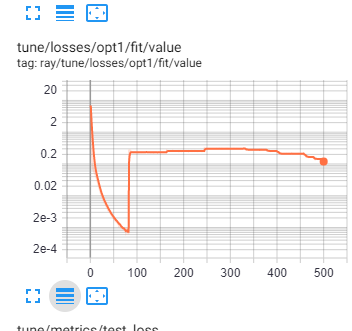
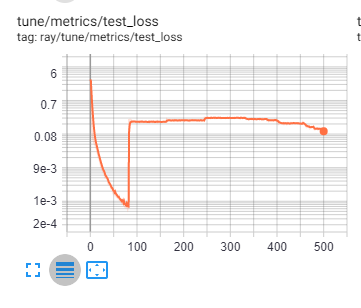

On the images, some green pixels are added, and they do not disappear

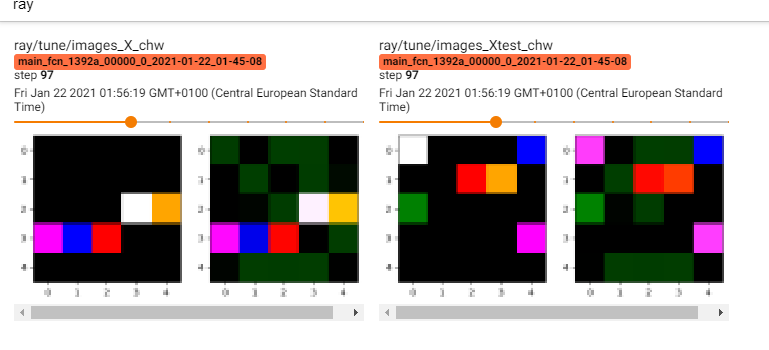

In [59]:
ckpt_dir = '/home/sergei/ray_results/dots/main_fcn_b9909_00000_0_2021-01-22_03-44-19'

In [60]:
%load_ext autoreload
%autoreload 2
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "-1"
import torch
import numpy as np
from matplotlib import pyplot as plt
import torch
from causal_analysis.helpers import get_df_from_logdir, CPU_Unpickler
import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
def get_ckpt_n(ckpt):
    """Get the number of the checkpoint."""
    idx = ckpt.find('checkpoint')
    ckpt = ckpt[idx:]
    n = int(ckpt.split('_')[1])
    return n
assert get_ckpt_n('sdfsdfcheckpoint_5000') == 5000

checkpoints = sorted(filter(lambda x: x.startswith('checkpoint'), os.listdir(ckpt_dir)), key=get_ckpt_n)
checkpoints = [os.path.join(ckpt_dir, x) for x in checkpoints]

In [62]:
df = get_df_from_logdir(ckpt_dir)

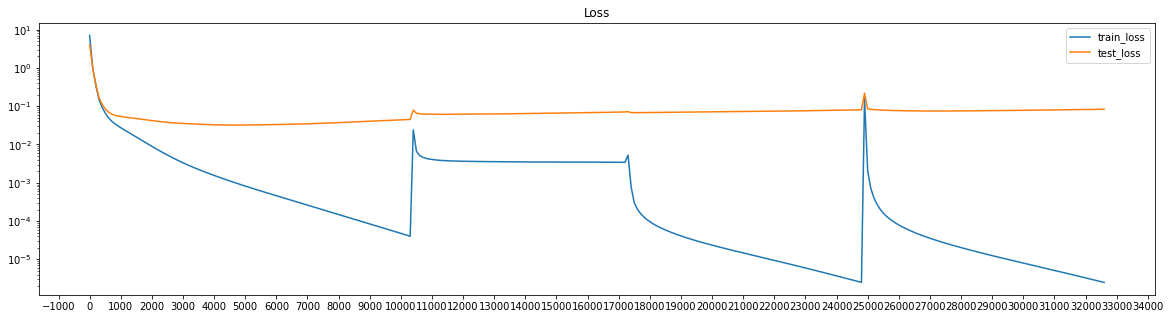

In [64]:
plt.figure(figsize=(20, 5))
plt.title("Loss")
plt.plot(df.epochs, df['losses/opt1/fit/value'], label='train_loss')
plt.plot(df.epochs, df['metrics/test_loss'], label='test_loss')
plt.yscale('log')
plt.legend()
plt.locator_params(axis='x', nbins=40)
plt.show()

In [84]:
idx1 = 90
idx2 = 120
cidx1 = idx1 // 10
cidx2 = idx2 // 10

In [85]:
df['losses/opt1/fit/value'][idx1], df['losses/opt1/fit/value'][idx2]

(8.465818245895207e-05, 0.003647117642685771)

In [86]:
checkpoints[cidx1], checkpoints[cidx2]

('/home/sergei/ray_results/dots/main_fcn_b9909_00000_0_2021-01-22_03-44-19/checkpoint_9000',
 '/home/sergei/ray_results/dots/main_fcn_b9909_00000_0_2021-01-22_03-44-19/checkpoint_12000')

In [87]:
with open(os.path.join(checkpoints[cidx1], 'checkpoint'), 'rb') as f:
    learner8 = CPU_Unpickler(f).load()
with open(os.path.join(checkpoints[cidx2], 'checkpoint'), 'rb') as f:
    learner9 = CPU_Unpickler(f).load()

In [88]:
def compute_loss(data_batch, learner):
    ae = learner.trainables['autoencoder']
    delta = ae(data_batch) - data_batch
    delta = torch.abs(delta) ** 3.5
    delta = torch.mean(delta, dim=0)
    delta = torch.sum(delta)
    return delta

In [89]:
learner8

<DotsLearner>

In [90]:
data_batch = learner8._context['X_chw']

In [91]:
compute_loss(data_batch, learner8)

tensor(0.0430, grad_fn=<SumBackward0>)

In [92]:
compute_loss(data_batch, learner9)

tensor(0.0648, grad_fn=<SumBackward0>)

In [93]:
param8 = dict(learner8.autoencoder.model.named_parameters())
param9 = dict(learner9.autoencoder.model.named_parameters())

In [94]:
assert set(param8.keys()) == set(param9.keys())

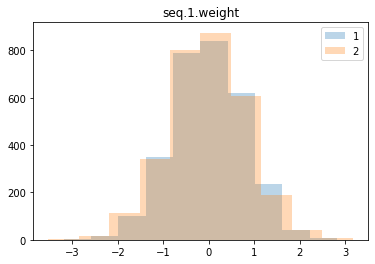

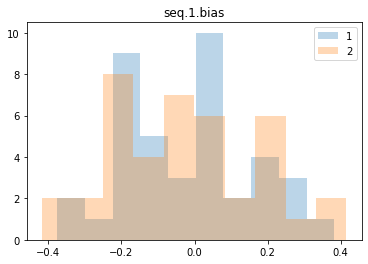

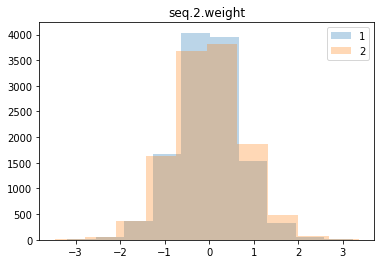

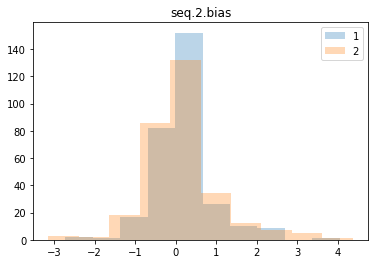

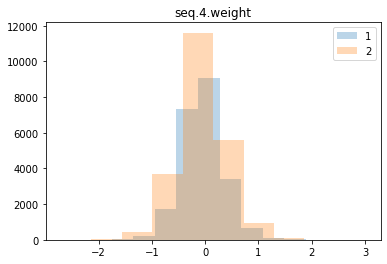

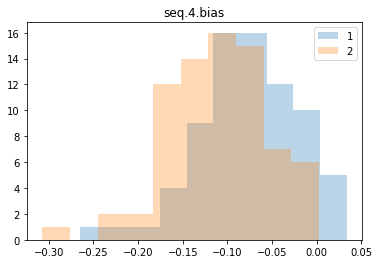

In [95]:
for key in param8.keys():
    plt.figure()
    
    for i, d in enumerate([param8, param9], 1):
#         plt.subplot(1, 2, i)
        plt.title(key)
        plt.hist(d[key].cpu().detach().numpy().flatten(), label=i, alpha=0.3)
    plt.legend()
    
    plt.show()

It seems, scale/loc are broken, and last bias is broken. Trying:

 * disabling new data collection
 * scaling layer
 
Last layer's bias can make sigmoid non-trainable anymore because of vanishing gradients.